## This Notebook is for replicating large portions of the original CATALYST paper

NOTE: "Replicate" Her means to get similar results and figures from the same data, not exact replication.
PalmettoBUG's Analysis class was intentionally designed to mimic CATALYST, so the results should be largel similar in both biological outputs and appearance.

Original CATALYST paper: "CyTOF workflow: differential discovery in high-throughput high-dimensional cytometry datasets" Nowicka et. al., 2019 https://doi.org/10.12688/f1000research.11622.3

Data source: http://flowrepository.org/public_experiment_representations/1704 -- only the PBMC Reference / BCR-XL FCS data files used
(directed here by the HDCytoData package: https://github.com/lmweber/HDCytoData)

    This is data originally from the following paper: "Multiplexed mass cytometry profiling of cellular states perturbed by small-molecule regulators" Bodenmiller et. al.,  (2012) https://doi.org/10.1038/nbt.2317. It's data was originally released publicly through a CytoBank experiment, but has been re-used in various other papers, such as the CATALYST paper and by the HDCytoData paper / package.

In [1]:
import time
start = time.time()

In [2]:
import os

import numpy as np
import pandas as pd

import palmettobug as pbug
print(time.time() - start)

The PalmettoBUG package is copyrighted 2024-2025 by the Medical University of South Carolina and licensed under the GPL-3 license.
It is free & open source software, can  be redistributed in compliance with the GPL3 license, and comes with absolutely no warranty.
In python, use palmettobug.print_license() to see the license, or use palmettobug.print_3rd_party_license_info() to print information
about the licenses and copyright of 3rd party software used in PalmettoBUG itself or in the creation of PalmettoBUG.
96.4217267036438


In [3]:
data_directory = "C:/Users/Default/Desktop/CyTOF_data"

In [4]:
####### This cell contains one-time-use code utilized to generate the panel & metadata .csv files --- need to add / consider a better way of doing this 
            ## creation of panel / metadata csv's outside the GUI! 
## Used to re-create the metadata (condition, patient_id), and panel infomation (type, state, none) marker classes from the original CATALYST paper

#import tkinter as tk
#app = tk.Tk()
#pbug.ImageProcessing.ImageAnalysisClass.direct_to_Analysis(app, data_directory)
#tk.mainloop()

In [5]:
Experiment = pbug.Analysis()
Experiment.load_data(data_directory + "/main")

Could not load regionprops data, presuming this is a solution-mode dataset -- Spatial analyses will not be possible.


In [6]:
Experiment.metadata

file_name sample_id patient_id  condition  \
0   PBMC8_30min_apatient1_Reference.fcs         0          1  Reference   
1   PBMC8_30min_apatient2_Reference.fcs         1          2  Reference   
2   PBMC8_30min_apatient3_Reference.fcs         2          3  Reference   
3   PBMC8_30min_apatient4_Reference.fcs         3          4  Reference   
4   PBMC8_30min_apatient5_Reference.fcs         4          5  Reference   
5   PBMC8_30min_apatient6_Reference.fcs         5          6  Reference   
6   PBMC8_30min_apatient7_Reference.fcs         6          7  Reference   
7   PBMC8_30min_apatient8_Reference.fcs         7          8  Reference   
8       PBMC8_30min_patient1_BCR-XL.fcs         8          1     BCR-XL   
9       PBMC8_30min_patient2_BCR-XL.fcs         9          2     BCR-XL   
10      PBMC8_30min_patient3_BCR-XL.fcs        10          3     BCR-XL   
11      PBMC8_30min_patient4_BCR-XL.fcs        11          4     BCR-XL   
12      PBMC8_30min_patient5_BCR-XL.fcs        12          5     BCR-XL   
13      PBMC8_30min_patient6_BCR-XL.fcs        13          6     BCR-XL   
14      PBMC8_30min_patient7_BCR-XL.fcs        14          7     BCR-XL   
15      PBMC8_30min_patient8_BCR-XL.fcs        15          8     BCR-XL   

    number_of_cells  
0              2739  
1             16725  
2              9434  
3              6906  
4             11962  
5             11038  
6             15974  
7             13670  
8              2838  
9             16675  
10            12252  
11             8990  
12             8543  
13             8622  
14            14770  
15            11653

In [7]:
## filter 'none' columns out -- original CATALYST paper does not use these at all in the main figures of the paper, as far as I can tell
Experiment.panel = Experiment.panel[Experiment.data.var['marker_class'] != 'none']
Experiment.data = Experiment.data[:,Experiment.data.var['marker_class'] != 'none']

In [8]:
## scale data

## for some reason, this data contains negative values (this should not be possible...unless some transformation has been performed on it?)
Experiment.data.X = Experiment.data.X - Experiment.data.X.min(axis = 0)

Experiment.do_scaling('%quantile',99.9)
print(time.time() - start)

100.98023414611816


In [9]:
#### Skipping this cell better recapitulates the Original CATALYST paper, however given the conclusion of that paper was that
## correcting for patient_id better separated the conditions, running this cell should help batch correct the sample before doing the analysis
Experiment.do_COMBAT('patient_id')

This batch correction will be lost / overwritten if a further scaling of the data is performed


591.5581884384155


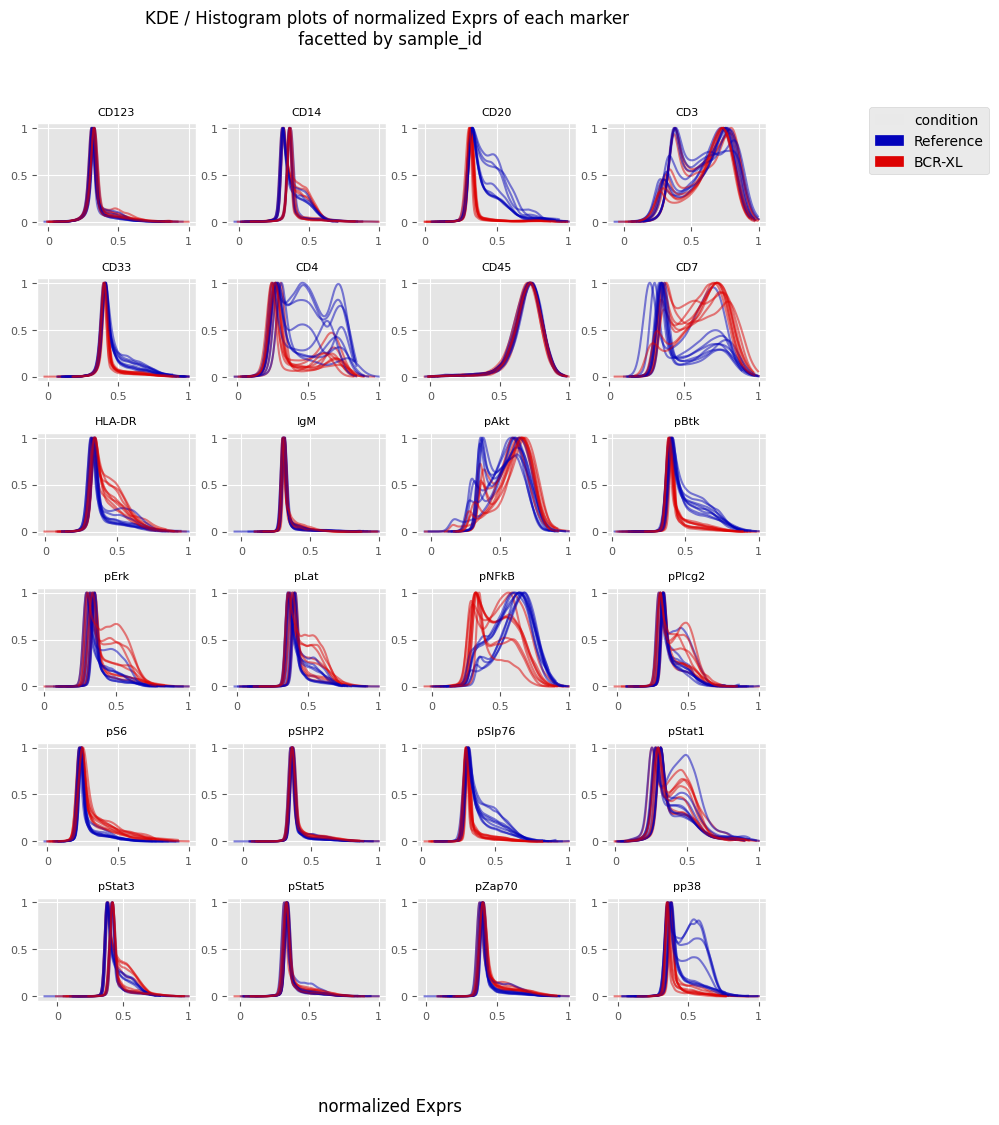

In [10]:
# This plot is extremely slow to run
fig = Experiment.plot_ROI_histograms(color_by = 'condition')
print(time.time() - start)
fig

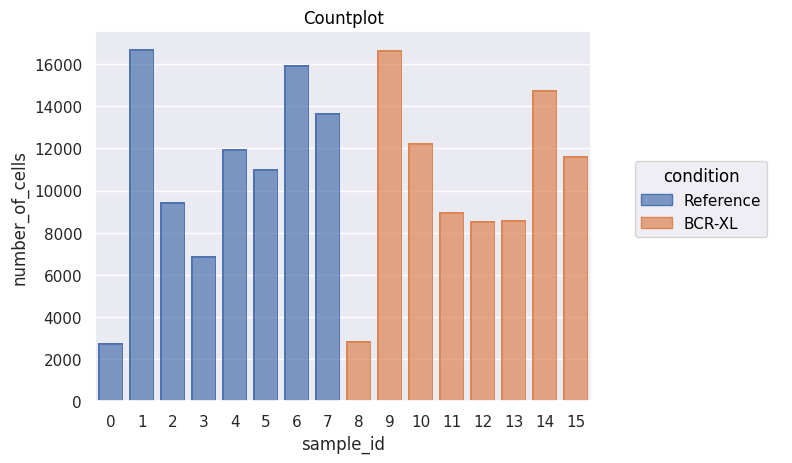

In [11]:
Experiment.plot_cell_counts()

604.9064402580261


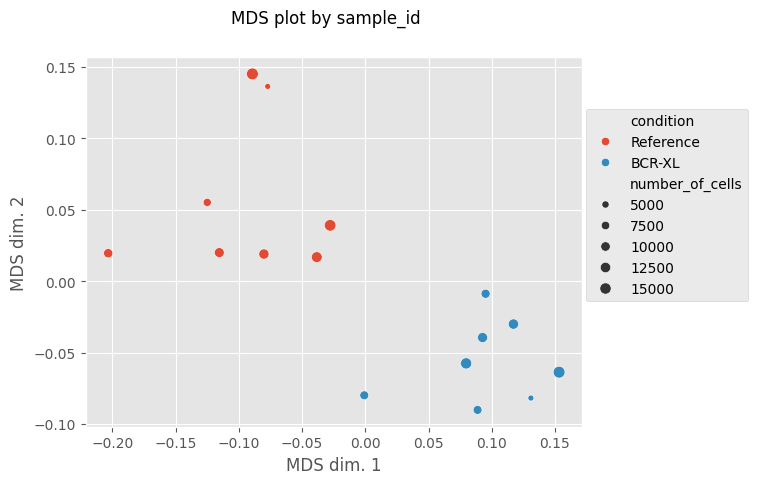

In [12]:
fig, MDS = Experiment.plot_MDS(seed = 42)
print(time.time() - start)
fig

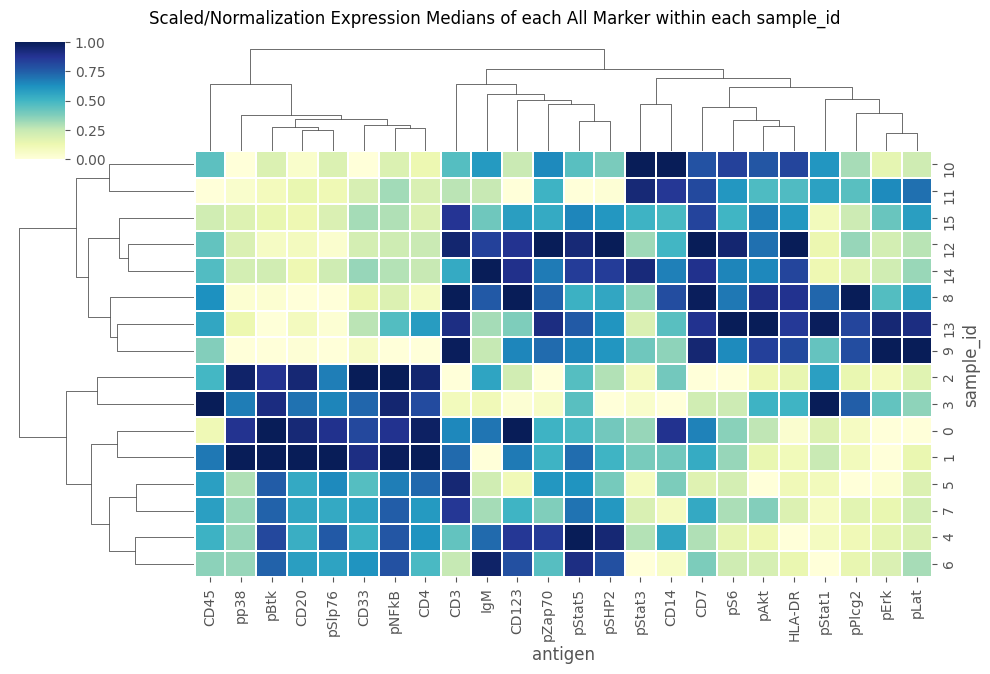

In [13]:
fig = Experiment.plot_medians_heatmap(marker_class = 'All', groupby = 'sample_id', scale_axis = 0, colormap = 'YlGnBu', figsize = (10,6.5))

929.8855044841766


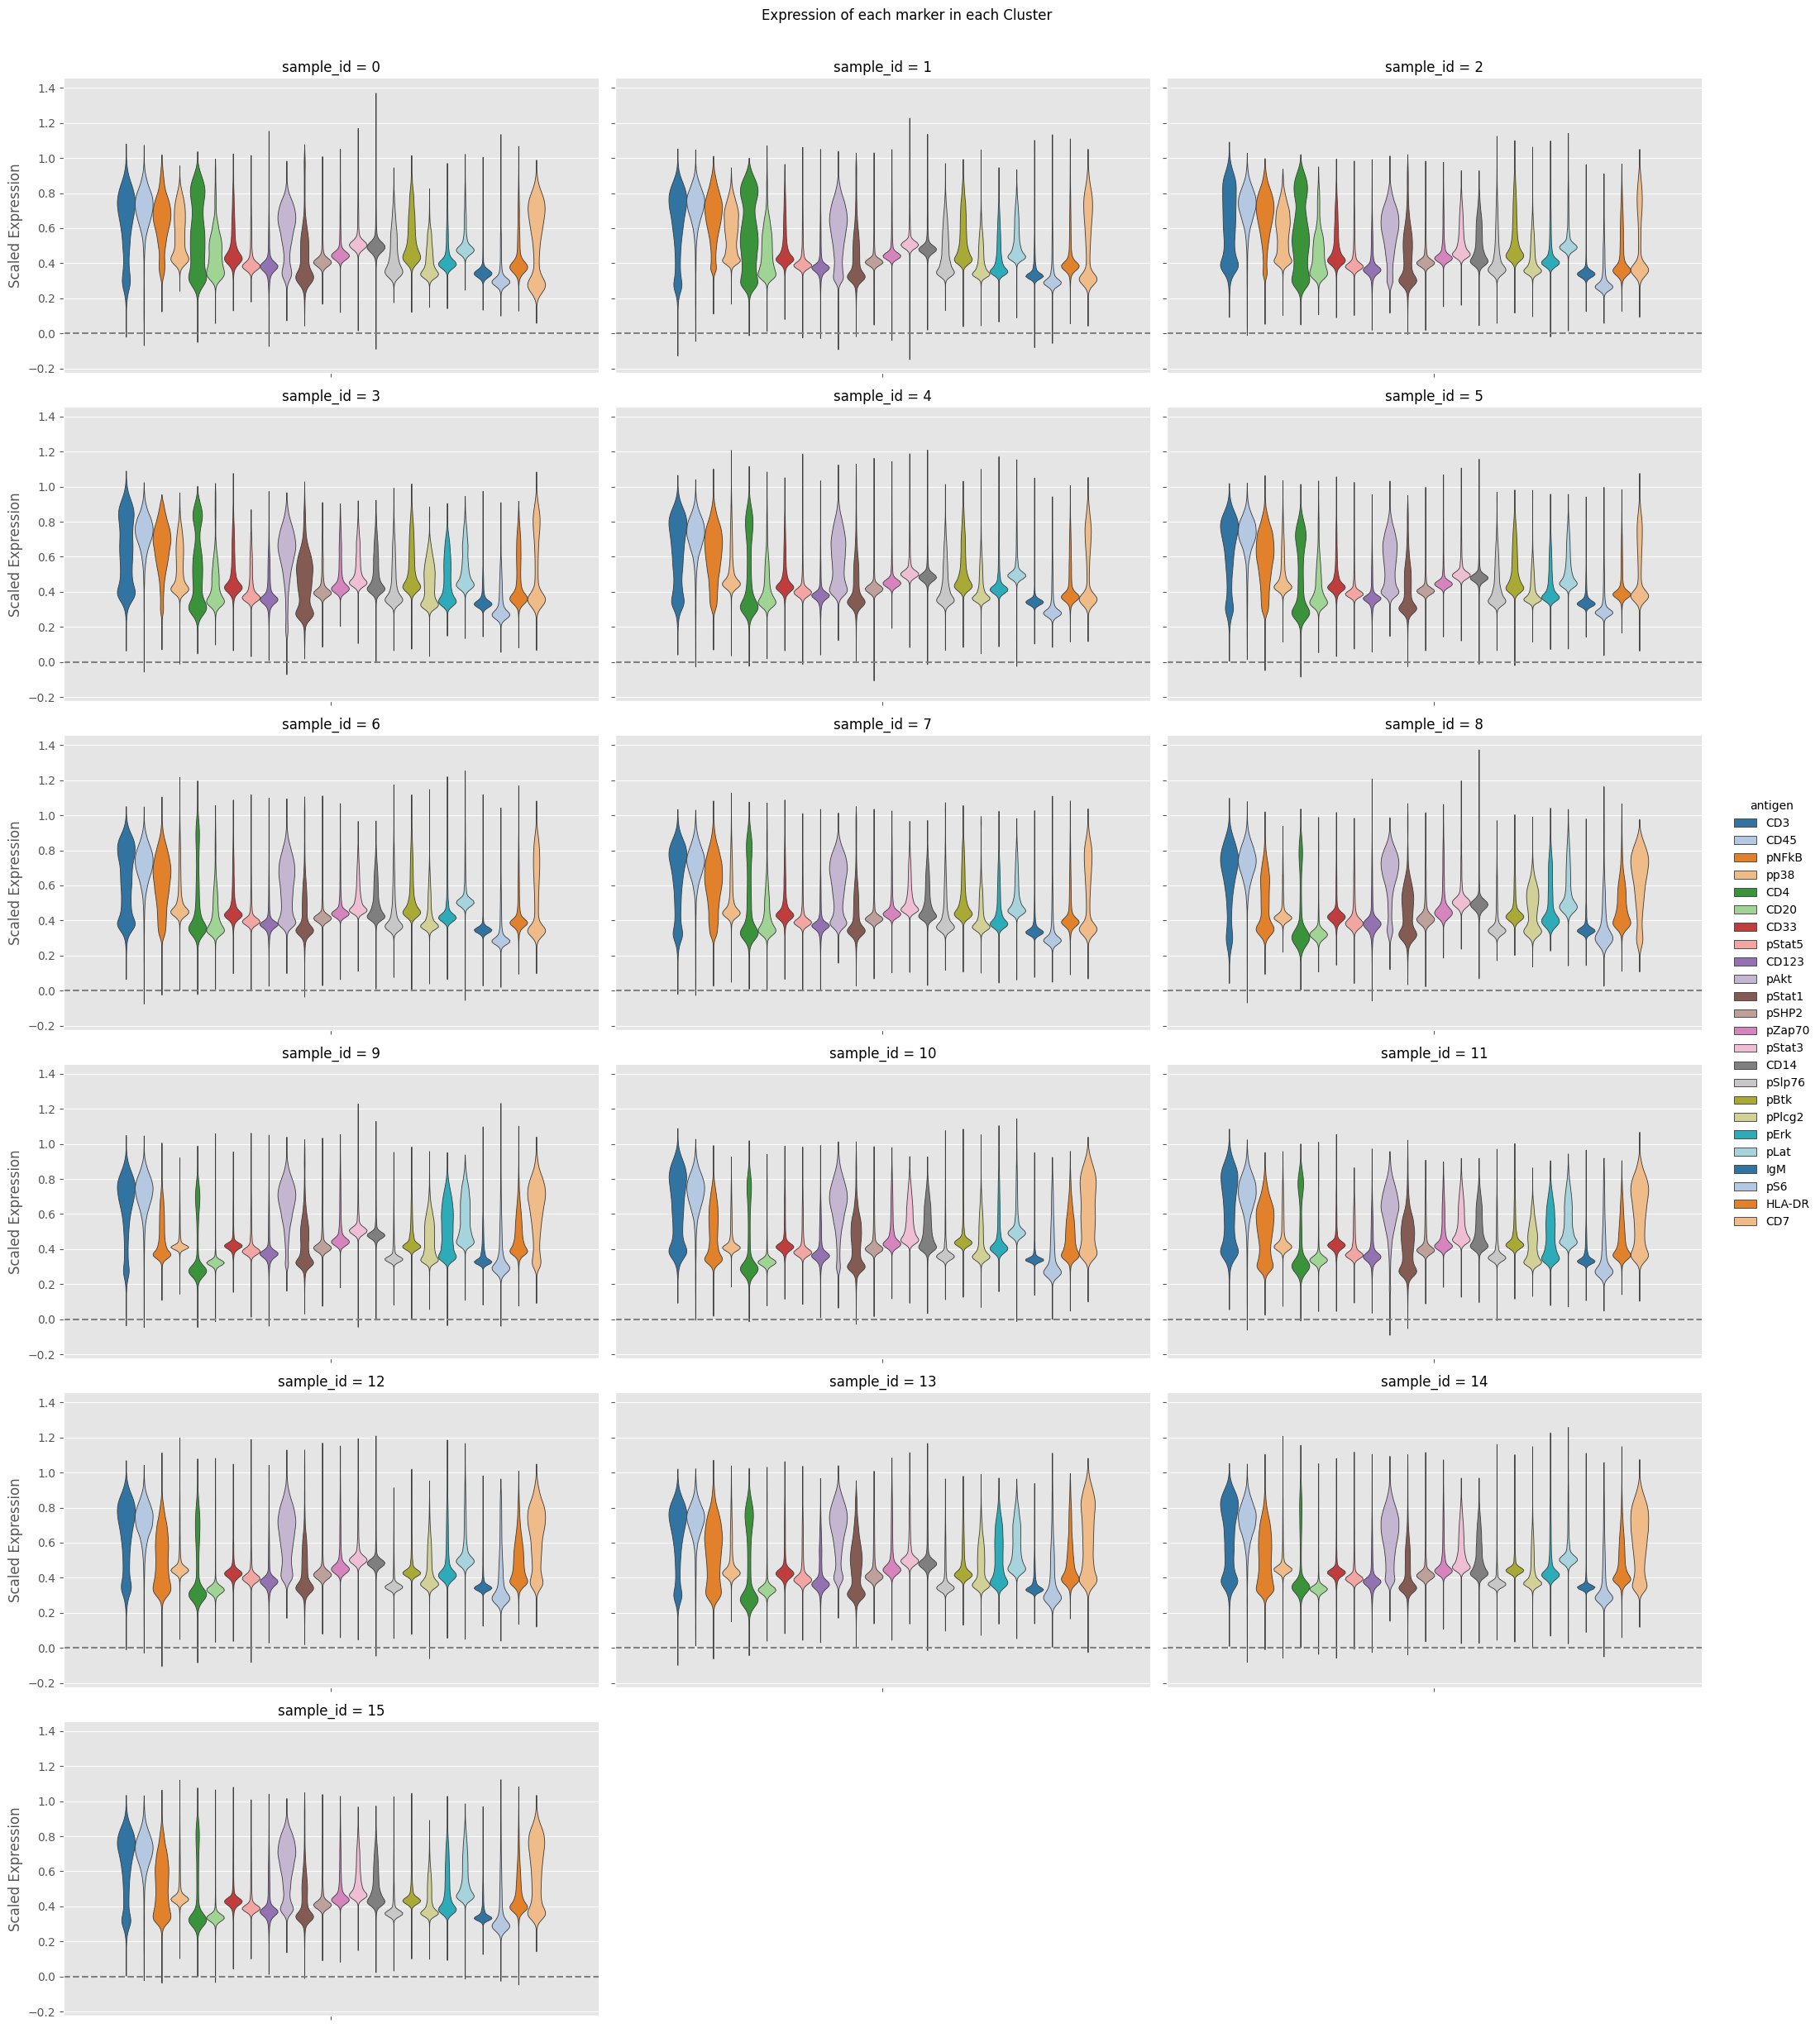

In [14]:
fig = Experiment.plot_cluster_distributions(groupby_column = 'sample_id', marker_class = 'All', comp_type = 'raw') 
print(time.time() - start)
fig

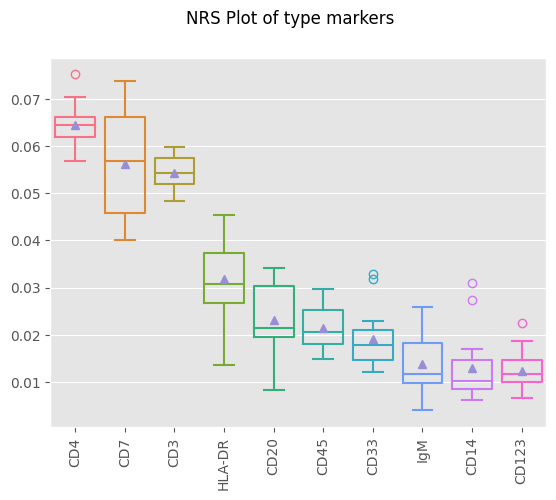

In [15]:
'''For exact replication of the CATALYST NRS figure, use the unscaled data (uncoment the line below).
This perfect replication is because the NRS plot function is directly translated from CATALYST, as
CATALYST is the only package I am aware of that uses / references NRS scores.'''
#Experiment.do_scaling('unscale')
fig = Experiment.plot_NRS()
if Experiment._scaling == 'unscale':
    Experiment.do_scaling()
    Experiment.do_COMBAT('patient_id')
fig

In [16]:
Experiment.do_flowsom(n_clusters = 30, XY_dim = 15, rlen = 50, marker_class = 'type', scale_within_cells = False, seed = 42)
print(time.time() - start)

2025-07-11 16:08:37.342 | DEBUG    | flowsom.main:__init__:82 - Reading input.
2025-07-11 16:08:37.358 | DEBUG    | flowsom.main:__init__:84 - Fitting model: clustering and metaclustering.
2025-07-11 16:10:38.536 | DEBUG    | flowsom.main:__init__:86 - Updating derived values.


1075.3018682003021


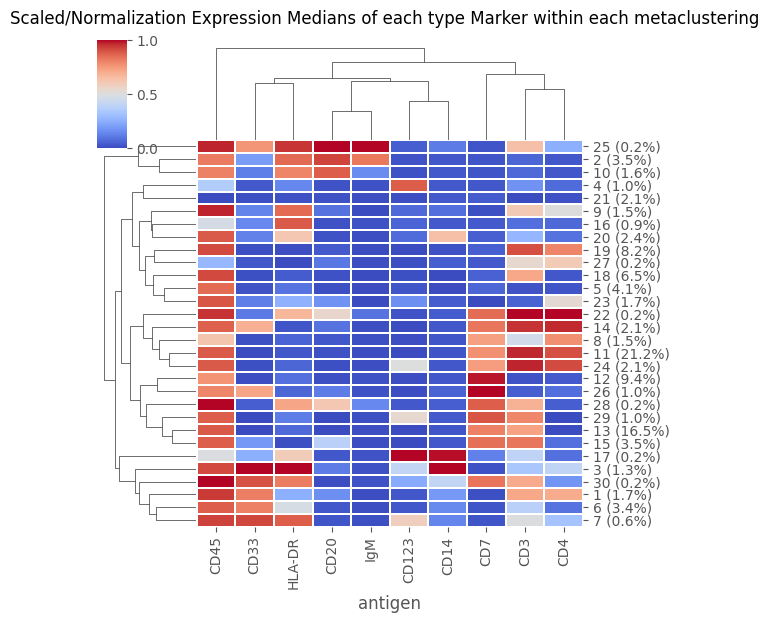

In [17]:
fig = Experiment.plot_medians_heatmap(marker_class = 'type', groupby = 'metaclustering', figsize = (6,6))

In [18]:
cell_types = ['Monocyte','other','NK cells','DC', 'B-cell IgMplus', 'B-cell IgMminus','CD8 T-cells', 'CD4 T-cells']
    ### note that ending a category with a + or - can mess with the GLM statistics function's output
annotations = {
    1:'CD4 T-cells',2:'B-cell IgMplus',3:'Monocyte',4:'DC',5:'Monocyte',
    6:'Monocyte',7:'Monocyte',8:'CD4 T-cells',9:'CD8 T-cells',10:'B-cell IgMminus',
    11:'CD4 T-cells',12:'NK cells',13:'CD8 T-cells',14:'CD4 T-cells',15:'CD8 T-cells',
    16:'Monocyte',17:'Monocyte',18:'CD8 T-cells',19:'CD4 T-cells',20:'Monocyte',
    21:'other',22:'CD4 T-cells',23:'Monocyte',24:'CD4 T-cells',25:'B-cell IgMplus',
    26:'NK cells',27:'CD8 T-cells',28:'CD8 T-cells',29:'CD8 T-cells',30:'CD8 T-cells'
}

1197.6761107444763


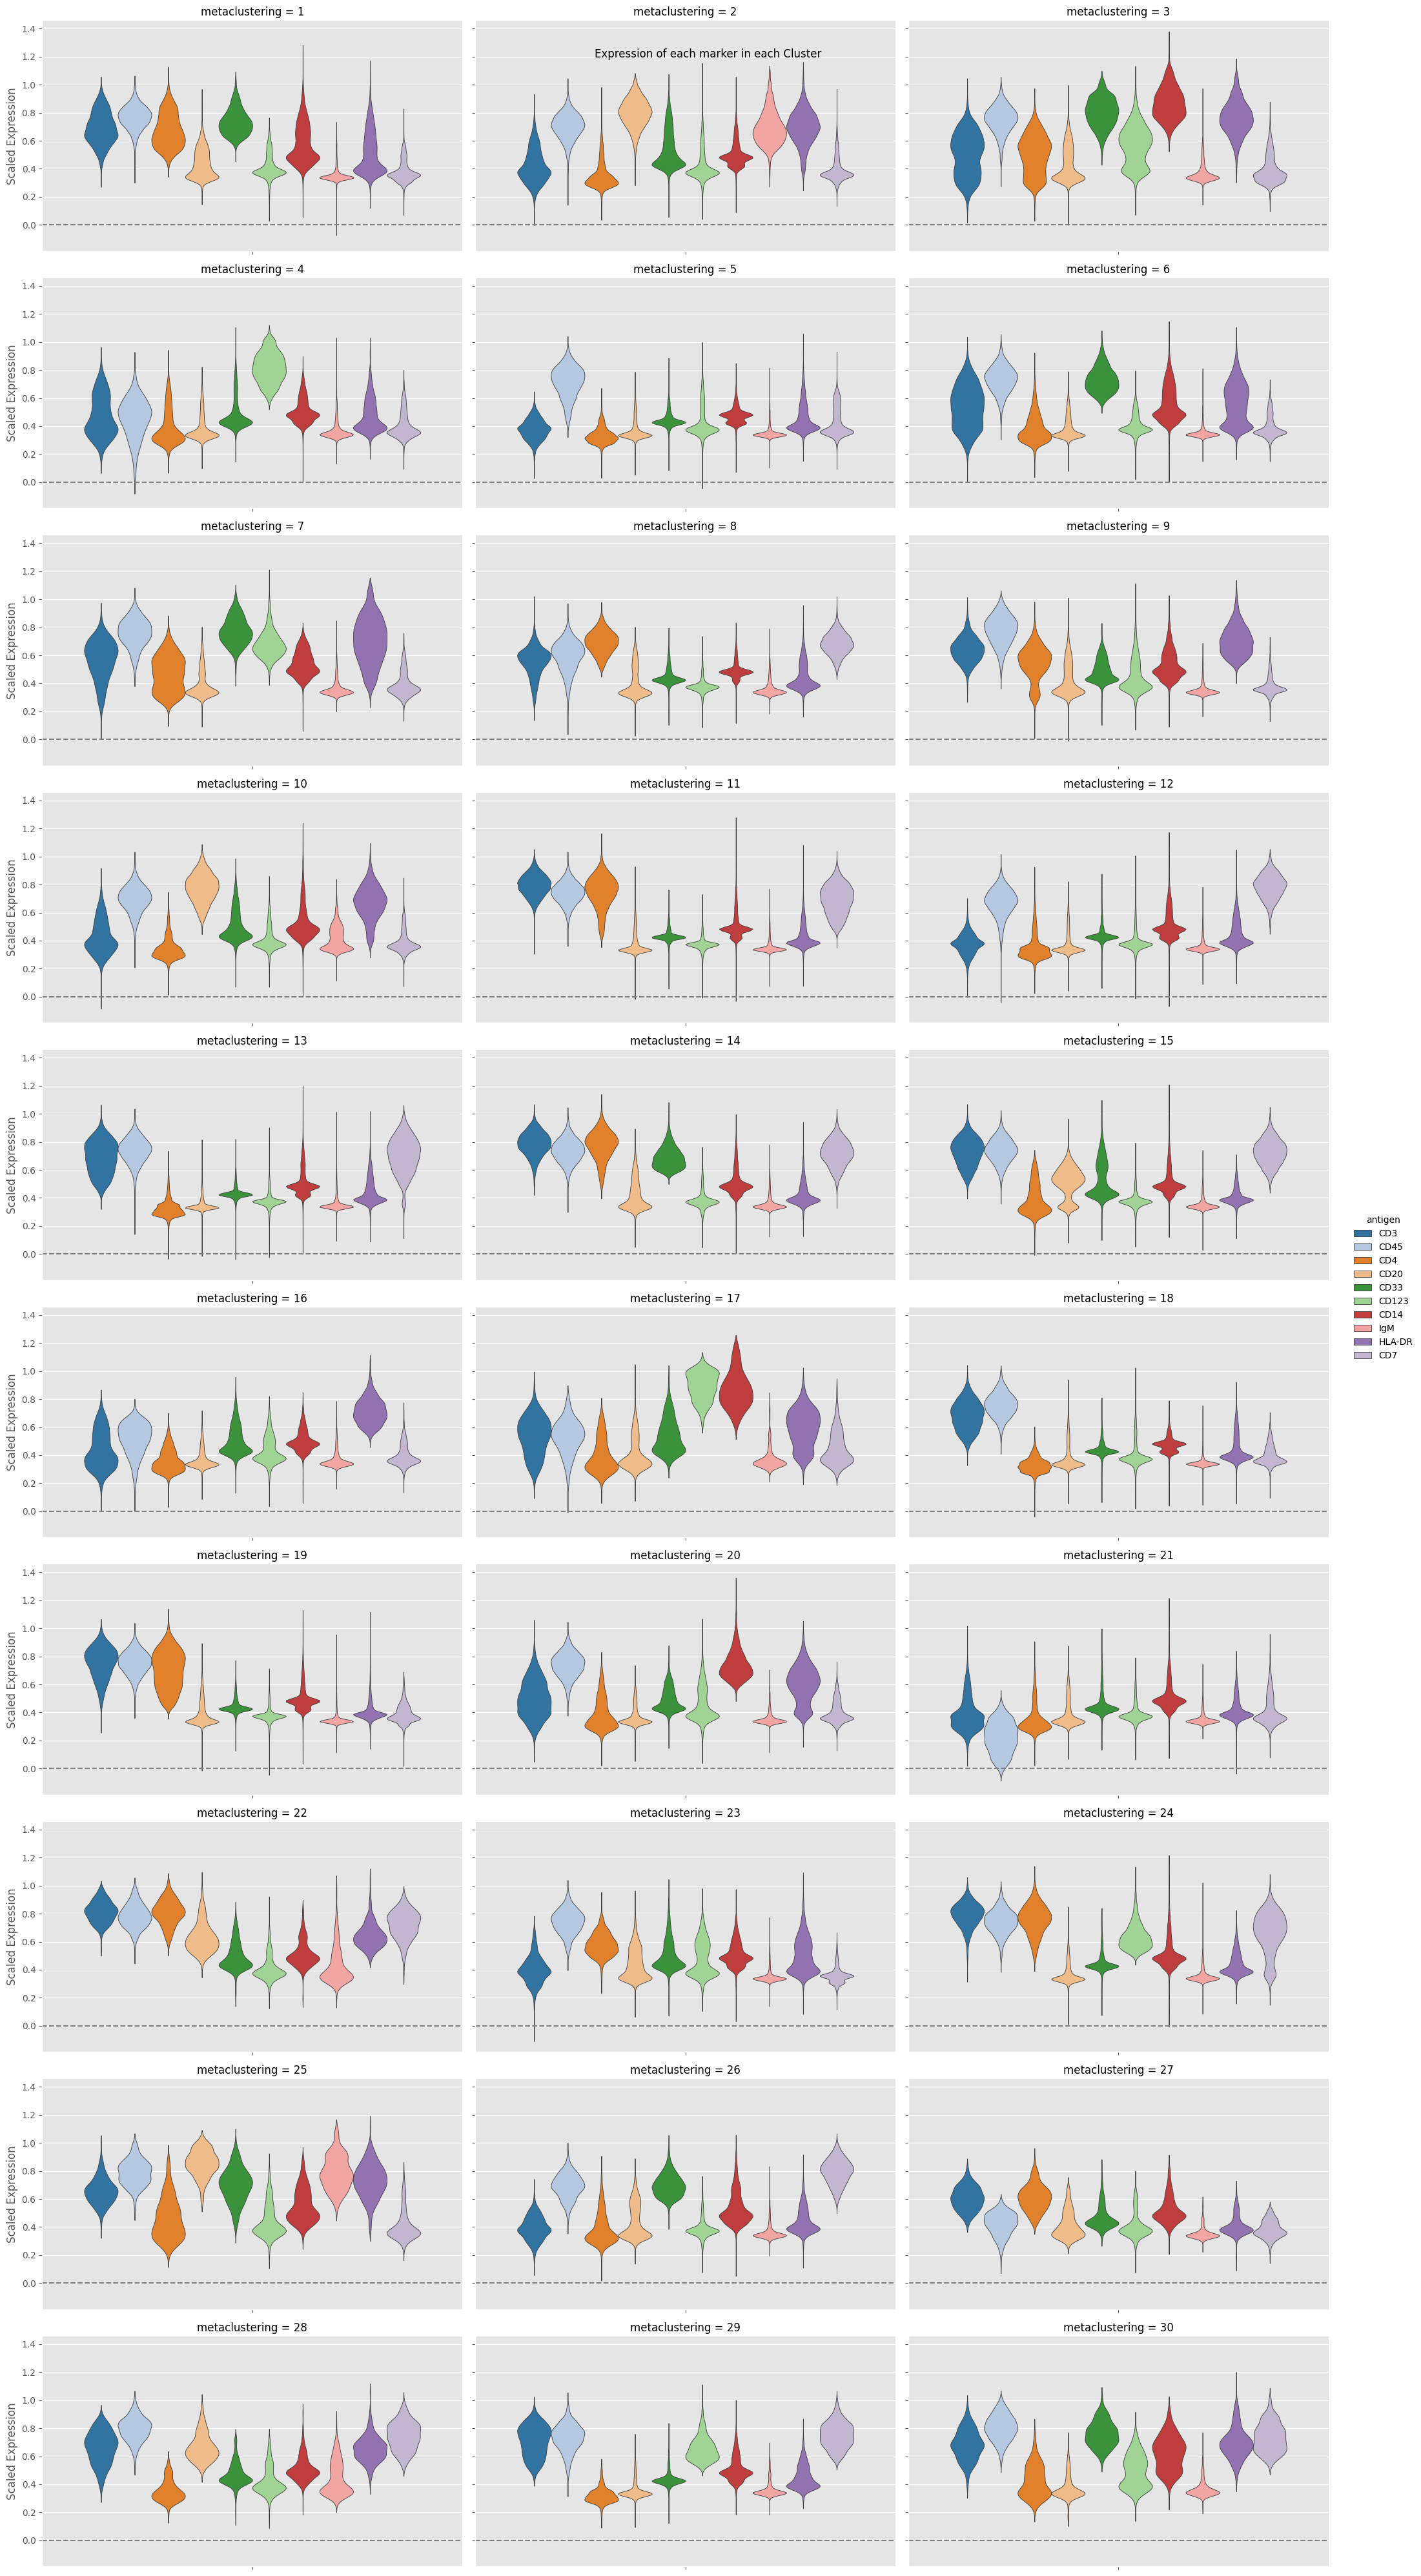

In [19]:
fig = Experiment.plot_cluster_distributions()
print(time.time() - start)
fig

In [20]:
Experiment.do_PCA(marker_class = 'type', cell_number = 1000, seed = 42)

1215.8790037631989


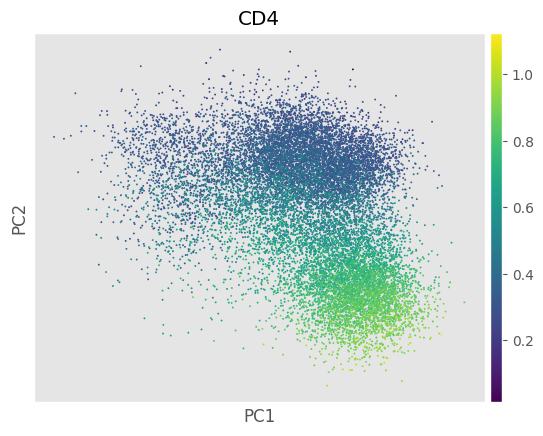

In [21]:
fig = Experiment.plot_PCA(color_by = 'CD4')
print(time.time() - start)
fig

In [22]:
Experiment.do_UMAP(marker_class = 'type', cell_number = 1000, seed = 42, n_neighbors = 15, min_dist = 0.1)

C:\Users\benca\miniforge3\envs\main\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


1524.873789548874


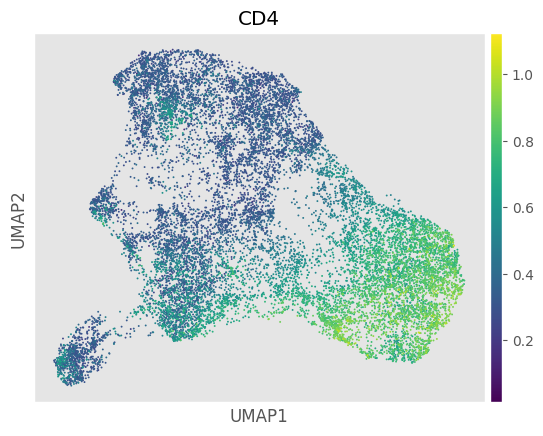

In [23]:
fig = Experiment.plot_UMAP(color_by = 'CD4')
print(time.time() - start)
fig

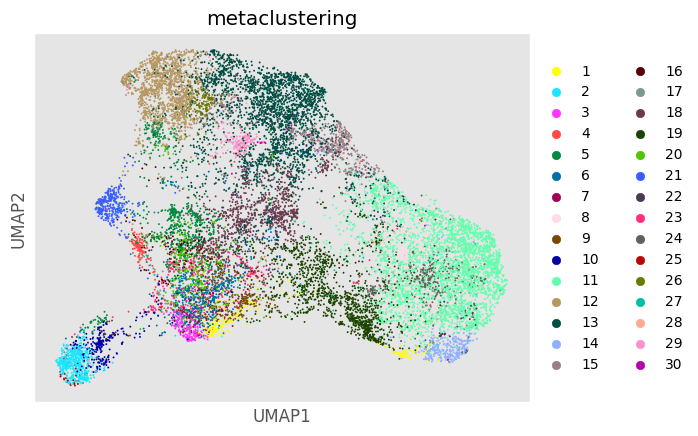

In [24]:
Experiment.plot_UMAP(color_by = 'metaclustering')

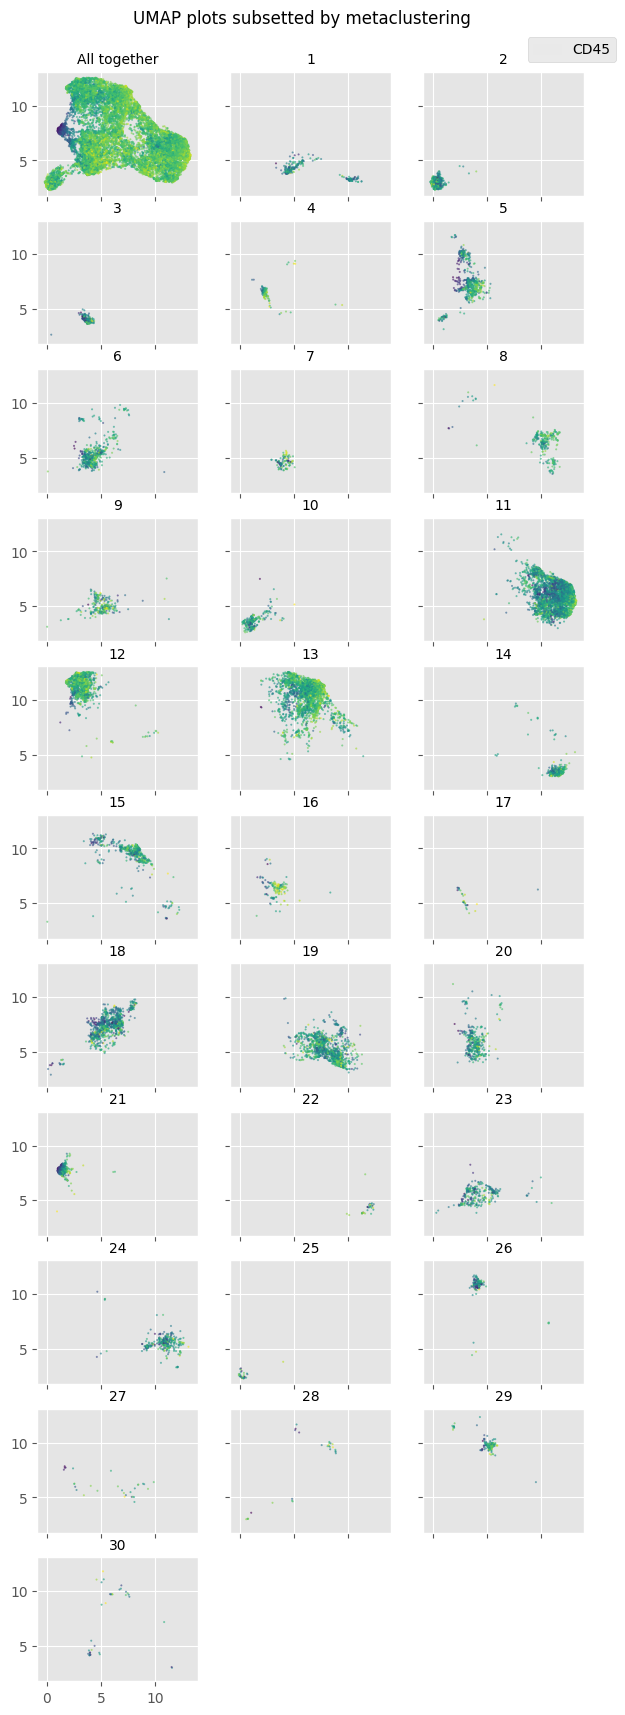

In [25]:
Experiment.plot_facetted_DR(color_by = 'CD45', subsetting_column = 'metaclustering')

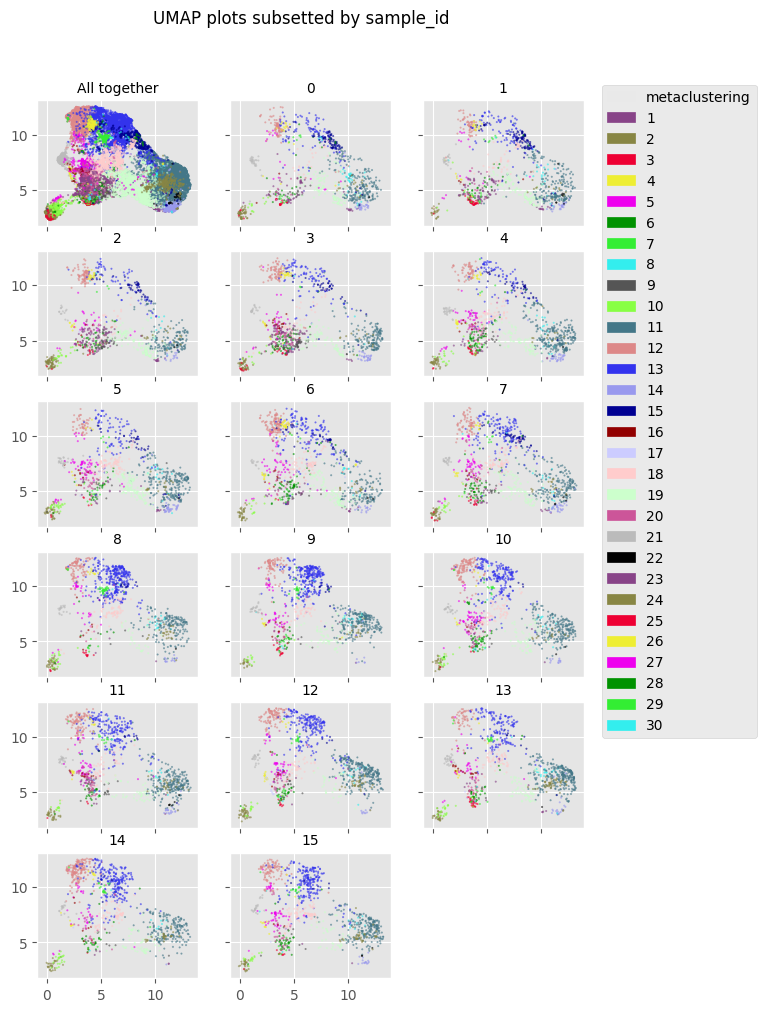

In [26]:
Experiment.plot_facetted_DR(color_by = 'metaclustering', subsetting_column = 'sample_id')

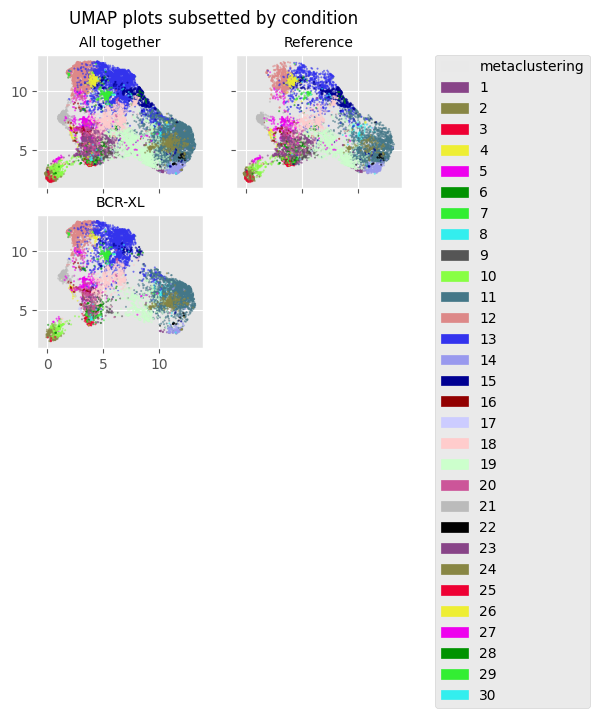

In [27]:
Experiment.plot_facetted_DR(color_by = 'metaclustering', subsetting_column = 'condition')

C:\Users\Default\Desktop\PalmettoBUG\palmettobug\Analysis_functions\Analysis.py:1786: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  down_anndata.obs[i] = down_anndata.obs[i].astype('category')


1580.1212112903595


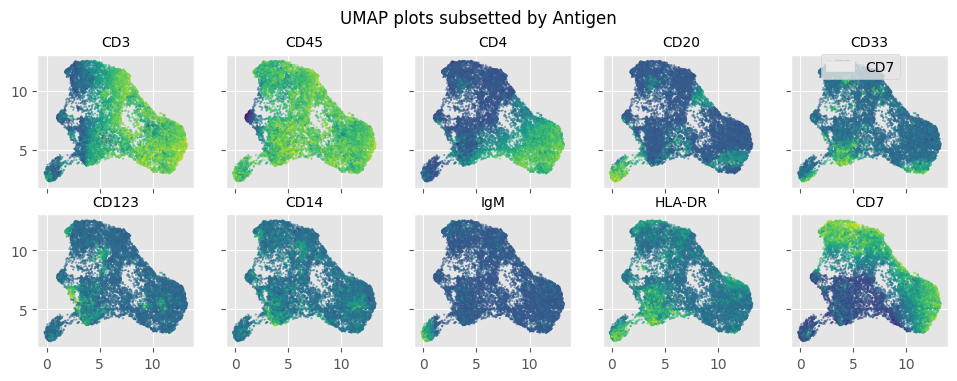

In [28]:
fig = Experiment.plot_facetted_DR_by_antigen(marker_class = ['type'], number_of_columns = 5)
print(time.time() - start)
fig

In [29]:
annotations = {
    1:'CD4 T-cells',2:'B-cell IgMplus',3:'Monocyte',4:'DC',5:'Monocyte',
    6:'Monocyte',7:'Monocyte',8:'CD4 T-cells',9:'CD8 T-cells',10:'B-cell IgMminus',
    11:'CD4 T-cells',12:'NK cells',13:'CD8 T-cells',14:'CD4 T-cells',15:'CD8 T-cells',
    16:'Monocyte',17:'Monocyte',18:'CD8 T-cells',19:'CD4 T-cells',20:'Monocyte',
    21:'other',22:'CD4 T-cells',23:'Monocyte',24:'CD4 T-cells',25:'B-cell IgMplus',
    26:'NK cells',27:'CD8 T-cells',28:'CD8 T-cells',29:'CD8 T-cells',30:'CD8 T-cells'
}

Experiment.data.obs['merging'] = Experiment.data.obs['metaclustering'].astype('int').replace(annotations).astype('category')
Experiment.UMAP_embedding.obs['merging'] = Experiment.UMAP_embedding.obs['metaclustering'].astype('int').replace(annotations).astype('category')

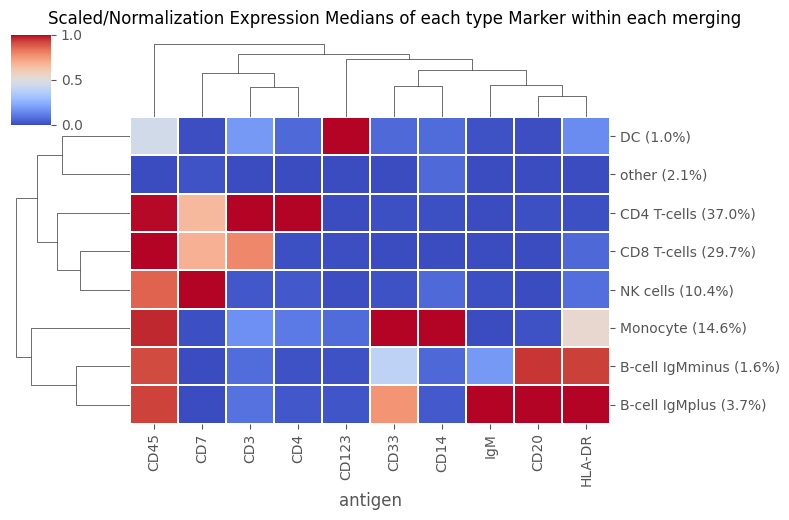

In [30]:
fig = Experiment.plot_medians_heatmap(marker_class = 'type', groupby = 'merging', figsize = (8,5))

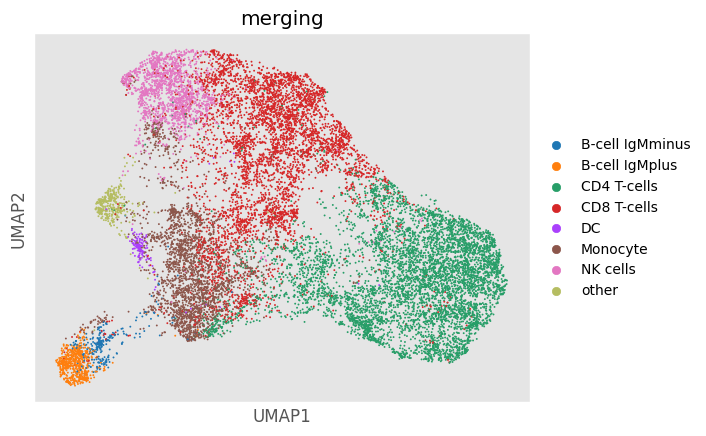

In [31]:
Experiment.plot_UMAP(color_by = 'merging')

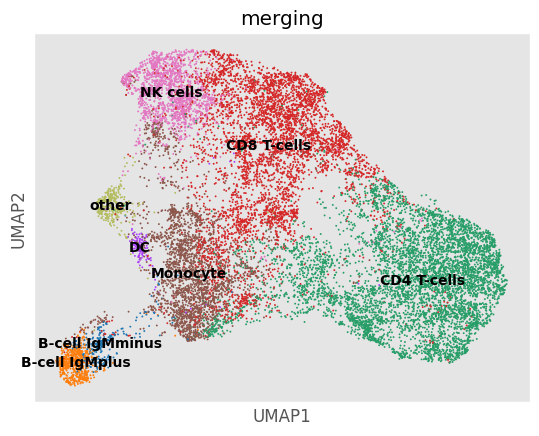

In [32]:
Experiment.plot_UMAP(color_by = 'merging', legend_loc = 'on data')

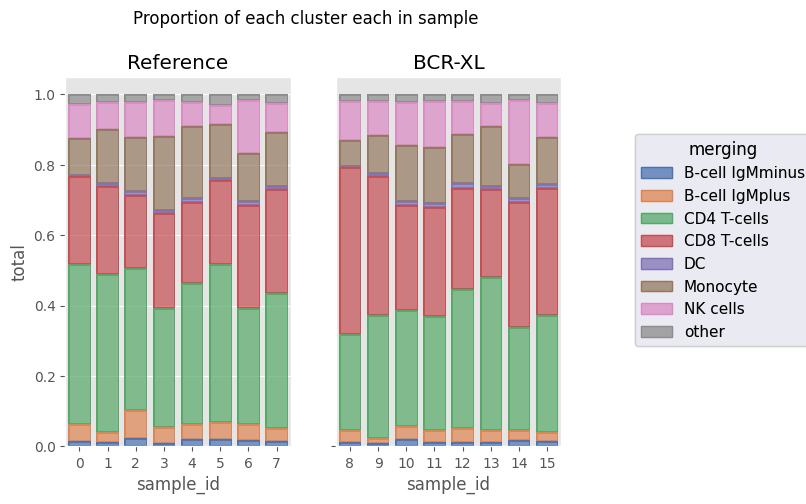

In [33]:
Experiment.plot_cluster_abundance_1(groupby_column = 'merging')

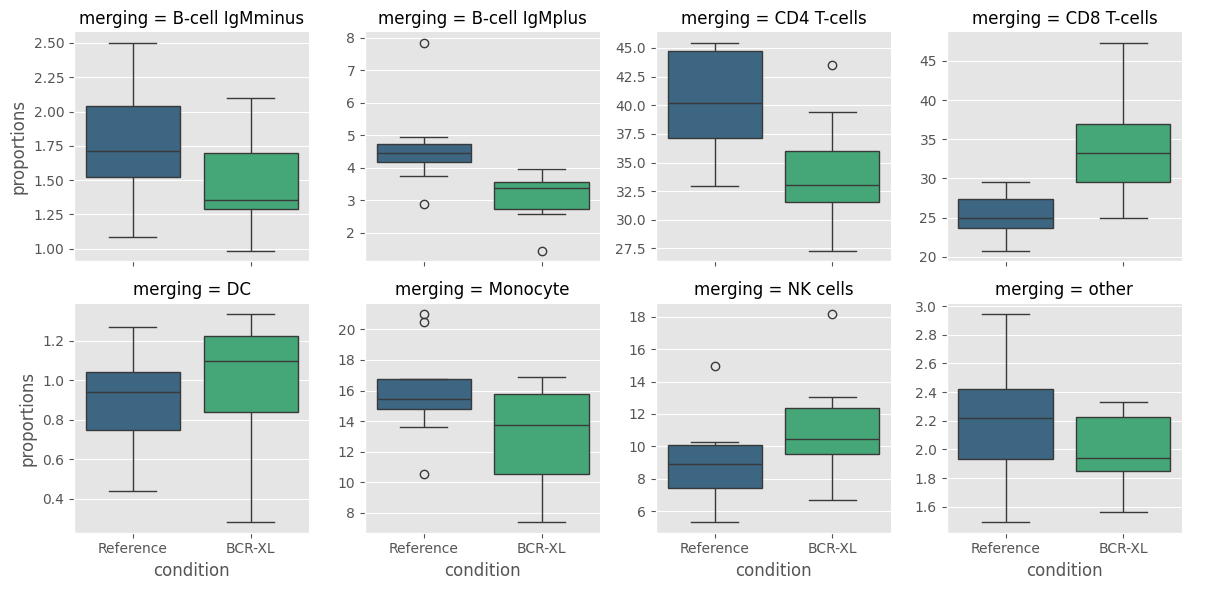

In [34]:
Experiment.plot_cluster_abundance_2(groupby_column = 'merging', plot_type = 'boxplot')

1634.9251630306244


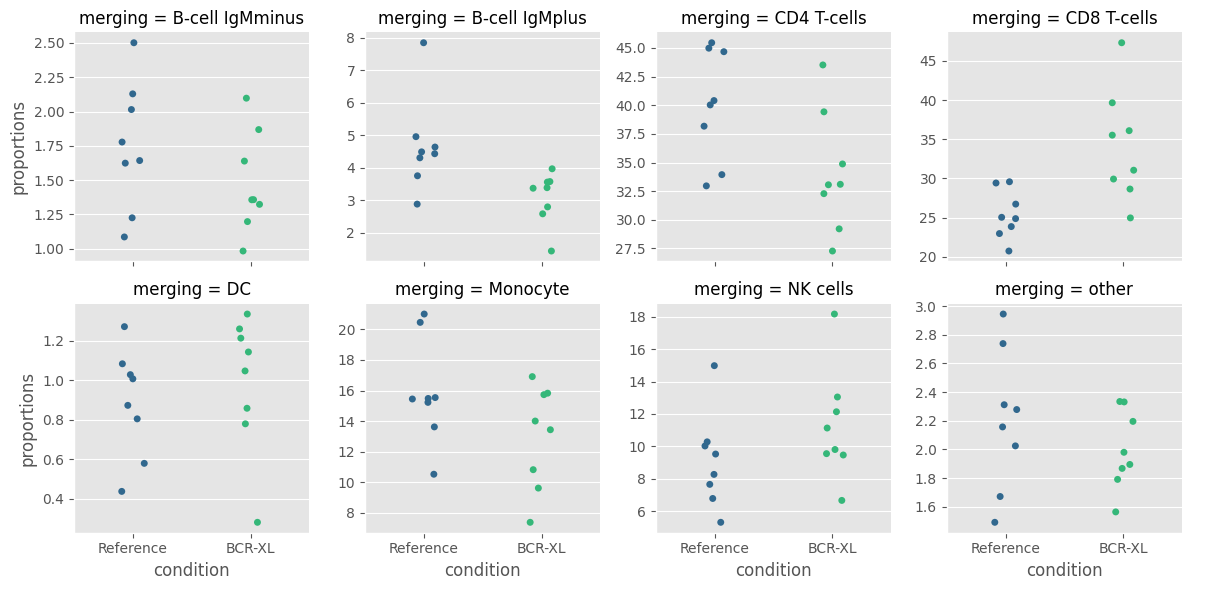

In [35]:
fig = Experiment.plot_cluster_abundance_2(groupby_column = 'merging', plot_type = 'stripplot')
print(time.time() - start)
fig

In [36]:
Experiment.do_abundance_ANOVAs()

f statistics   p_value    p_adj  Reference mean %  \
CD8 T-cells           10.2700  0.006354  0.05083           25.4100   
B-cell IgMplus         7.3800  0.016710  0.06683            4.6620   
CD4 T-cells            5.5790  0.033200  0.08854           40.0800   
Monocyte               3.0090  0.104700  0.20950           15.9100   
NK cells               1.8280  0.197800  0.28710            9.1070   
B-cell IgMminus        1.6840  0.215300  0.28710            1.7500   
other                  1.0940  0.313200  0.35800            2.2020   
DC                     0.4468  0.514700  0.51470            0.8855   

                 Reference stdev  BCR-XL mean %  BCR-XL stdev  
CD8 T-cells               3.0650        34.1500        7.0860  
B-cell IgMplus            1.4350         3.0850        0.7983  
CD4 T-cells               4.8720        34.0900        5.2590  
Monocyte                  3.4260        12.9600        3.3800  
NK cells                  2.9140        11.2500        3.4010  
B-cell IgMminus           0.4664         1.4780        0.3661  
other                     0.4894         1.9950        0.2731  
DC                        0.2733         0.9894        0.3444

In [37]:
Experiment.do_count_GLM(variable = 'condition', conditions = ['Reference','BCR-XL'], groupby_column = 'merging', family = 'NegativeBinomial')

C:\Users\benca\miniforge3\envs\main\lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


comparison          merging   pvalue    p_adj Reference est. avg  \
0  Reference vs. BCR-XL      CD8_T_cells  0.00041  0.00328               25.4   
3  Reference vs. BCR-XL   B_cell_IgMplus  0.00492  0.01970               4.66   
1  Reference vs. BCR-XL      CD4_T_cells   0.0194  0.05170               40.1   
2  Reference vs. BCR-XL         Monocyte    0.101  0.20200               15.9   
4  Reference vs. BCR-XL         NK_cells    0.163  0.26000               9.11   
7  Reference vs. BCR-XL  B_cell_IgMminus    0.195  0.26000               1.75   
6  Reference vs. BCR-XL            other    0.294  0.33600                2.2   
5  Reference vs. BCR-XL               DC    0.567  0.56700              0.887   

  Reference 95% CI +/- BCR-XL est. avg BCR-XL 95% CI +/-  
0                 1.51            34.2              2.86  
3                0.485            3.08             0.455  
1                 1.96            34.1              2.36  
2                 1.41            13.0              1.63  
4                0.977            11.2              1.71  
7                0.161            1.48             0.193  
6                0.146            1.99             0.187  
5                0.122           0.992             0.194

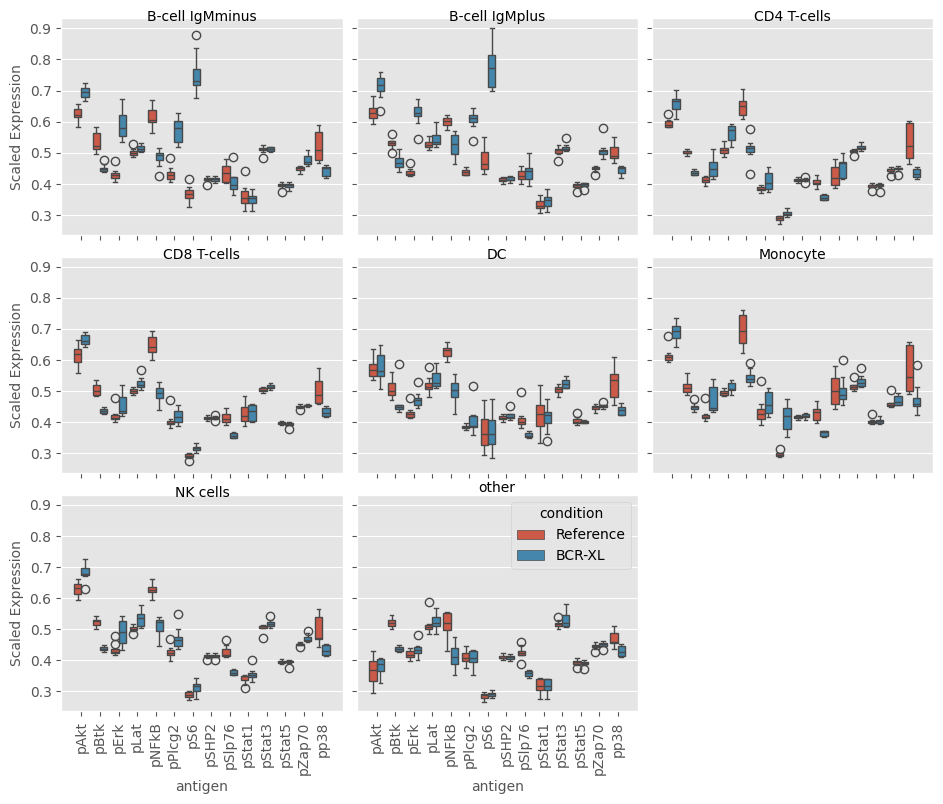

In [38]:
Experiment.plot_state_distributions(marker_class = 'state', 
                                 subset_column = 'merging', 
                                 colorby = 'condition')

In [39]:
df = Experiment.do_state_exprs_ANOVAs()
print(time.time() - start)
df.head(25)

1656.1441223621368


antigen          merging       p_value         p_adj  F statistic  \
10    pBtk      CD4 T-cells  1.062000e-12  7.678000e-11       561.90   
14    pBtk         NK cells  1.371000e-12  7.678000e-11       541.30   
66  pSlp76      CD4 T-cells  2.284000e-11  8.527000e-10       357.90   
53     pS6         Monocyte  9.933000e-11  2.781000e-09       287.60   
17    pErk   B-cell IgMplus  3.525000e-10  7.252000e-09       237.80   
70  pSlp76         NK cells  3.885000e-10  7.252000e-09       234.40   
11    pBtk      CD8 T-cells  6.499000e-10  1.040000e-08       216.80   
48     pS6  B-cell IgMminus  1.635000e-09  2.072000e-08       188.40   
67  pSlp76      CD8 T-cells  1.665000e-09  2.072000e-08       187.90   
15    pBtk            other  2.439000e-09  2.732000e-08       177.20   
41  pPlcg2   B-cell IgMplus  1.185000e-08  1.207000e-07       138.80   
71  pSlp76            other  1.938000e-08  1.809000e-07       128.50   
68  pSlp76               DC  4.609000e-08  3.971000e-07       112.00   
16    pErk  B-cell IgMminus  5.292000e-08  4.234000e-07       109.60   
35   pNFkB      CD8 T-cells  6.188000e-08  4.620000e-07       106.80   
51     pS6      CD8 T-cells  2.037000e-07  1.404000e-06        88.09   
49     pS6   B-cell IgMplus  2.131000e-07  1.404000e-06        87.44   
32   pNFkB  B-cell IgMminus  3.268000e-07  2.033000e-06        81.49   
38   pNFkB         NK cells  4.190000e-07  2.470000e-06        78.19   
69  pSlp76         Monocyte  5.691000e-07  3.187000e-06        74.29   
8     pBtk  B-cell IgMminus  7.202000e-07  3.841000e-06        71.40   
34   pNFkB      CD4 T-cells  8.654000e-07  4.406000e-06        69.22   
40  pPlcg2  B-cell IgMminus  1.756000e-06  8.551000e-06        61.31   
13    pBtk         Monocyte  3.130000e-06  1.461000e-05        55.43   
29    pLat         Monocyte  3.286000e-06  1.472000e-05        54.95   

    avg Reference mean exprs  Reference avg stdev  avg BCR-XL mean exprs  \
10                    0.5489             0.007554                 0.4738   
14                    0.5644             0.009350                 0.4799   
66                    0.4539             0.008027                 0.3799   
53                    0.3490             0.011760                 0.4706   
17                    0.4861             0.012050                 0.6238   
70                    0.4696             0.010440                 0.3991   
11                    0.5495             0.012460                 0.4752   
48                    0.4138             0.016980                 0.7229   
67                    0.4587             0.012510                 0.3858   
15                    0.5653             0.013250                 0.4826   
41                    0.4541             0.010260                 0.5872   
71                    0.4717             0.013660                 0.3911   
68                    0.4536             0.016450                 0.3910   
16                    0.4769             0.020180                 0.6073   
35                    0.6303             0.030050                 0.5045   
51                    0.3372             0.008347                 0.3842   
49                    0.4787             0.037240                 0.7409   
32                    0.5996             0.024880                 0.4951   
38                    0.6072             0.022190                 0.5107   
69                    0.4733             0.015300                 0.4134   
8                     0.5718             0.020210                 0.4969   
34                    0.6331             0.030460                 0.5156   
40                    0.4560             0.016120                 0.5577   
13                    0.5592             0.014800                 0.5033   
29                    0.5312             0.005894                 0.5546   

    BCR-XL avg stdev  
10          0.004819  
14          0.004277  
66          0.007614  
53          0.016520  
17          0.022200  
70          0.0

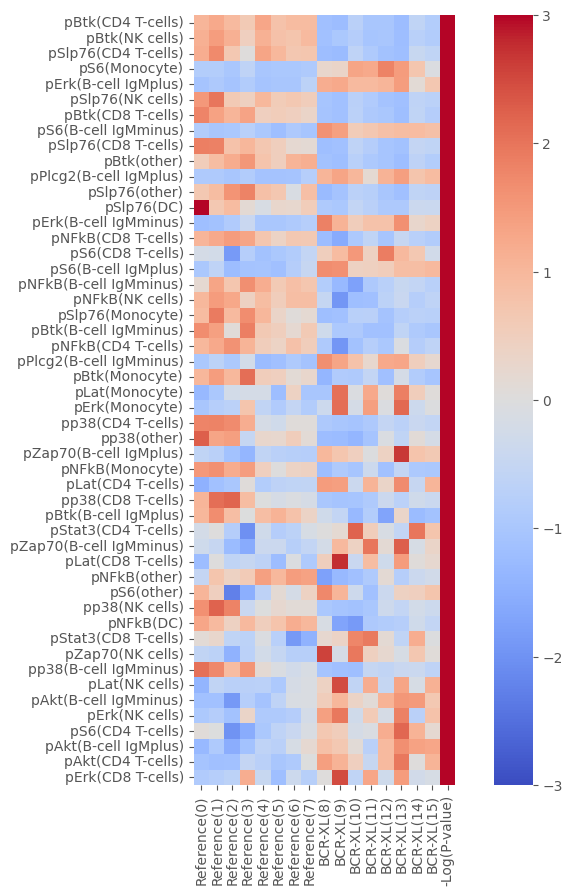

In [40]:
figure = Experiment.plot_state_p_value_heatmap(stats_df = df)
figure

In [41]:
print(time.time() - start)

1662.302865743637
